本测试将使用 [易方达沪深300发起式ETF-510310](https://gu.qq.com/sh510310) 对 **周内效应** 进行验证。

> 周内效应：http://erj.cn/UploadFiles/%E4%B8%AD%E5%9B%BD%E8%82%A1%E7%A5%A8%E5%B8%82%E5%9C%BA%E7%9A%84_%E5%91%A8%E5%86%85%E6%95%88%E5%BA%94_.pdf

## 验证规则

验证时采用如下规则：
1. 验证时预计取过往 *3* 年的数据作为 *训练集* ，后 *1*年的数据作为 *验证集*；

> 举例来说就是取 `2014-01-01~2016-12-31` 的数据作为训练集，再采用 `2017-01-01~2017-12-31` 的数据作为验证集。

2. 验证时的基准数据采用相同时间段的 [沪深300-399300](http://quotes.money.163.com/1399300.html) 的数据；
3. 判断上涨市/下跌市时使用 `20日SMA` 数据。当 *当日收盘价<20日SMA 时为下跌市*、*当日收盘价>20日SMA 时为上涨市*；

## 程序逻辑

### [上涨市/下跌市的程序判断逻辑](#%E4%B8%8A%E6%B6%A8%E5%B8%82/%E4%B8%8B%E8%B7%8C%E5%B8%82%E5%88%A4%E6%96%AD%E8%A7%84%E5%88%99)

### [买卖日期计算逻辑](#%E8%AE%A1%E7%AE%97%E4%B8%8D%E5%90%8C%E5%B8%82%E5%9C%BA%E4%B8%8B%E7%9A%84%E4%B9%B0%E5%8D%96%E6%97%A5%E6%9C%9F)

### [买入方式计算逻辑](#%E8%AE%A1%E7%AE%97%E4%B8%8D%E5%90%8C%E5%B8%82%E5%9C%BA%E4%B8%8B%E7%9A%84%E4%B9%B0%E5%85%A5%E6%96%B9%E5%BC%8F%EF%BC%9A)

## 结论

从[100万次](#100%E4%B8%87%E6%AC%A1)测试结果来看:

* 按照周内效应交易的结果，均可以跑赢基准，且盈利占比均超过50%；
* 按照上涨市和下跌市拆分后的结果明显好于不拆分的情况；
* 回看年份增加会带来一定的盈利几率；

In [2]:
import numpy as np
import talib
import pandas as pd
from tqdm import tqdm_notebook
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()
import matplotlib.pyplot as plt
import seaborn as sns
from gquant.backtest import backtest
from gquant.week_effect import *

plt.style.use('ggplot')

you are using non-interactive mdoel quantaxis


In [3]:
CODE='510310' #计算数据
BENCHMARK_CODE='399300' #基准代码
START='2013-03-06'#510310成立日期
END=QA.QAUtil.QADate.QA_util_today_str()#数据截止到今天。后面会根据不同的测试时间段对数据分段
INIT_CASH=10000#验证时的模拟初始资金
DEFAULT_MA=20#判断上涨/下跌市的SMA取值

In [13]:
def get_data(code=CODE,start=START,end=END,ma=DEFAULT_MA,dropna=True):
    """获取指数数据
    
    Args:
        code: 指数代码
        start: 数据开始时间
        end: 数据截止时间
        ma: 计算SMA时的时间段
    """
    data = QA.QA_fetch_index_day_adv(code,start=start,end=end).data.reset_index(level=1, drop=True)
    # 收盘价变化率
    data['收盘价变化率'] = data['close'].pct_change()
    data['date'] = data.index.get_level_values(0)
    data['date'] = pd.to_datetime(data['date'])
    # 星期一为0，星期天为6
    data['weekday'] = data['date'].dt.weekday
    # 明天星期
    data['nextday']=data['weekday'].shift(-1)
    # 昨天星期
    data['prevday']=data['weekday'].shift()
    # 简单移动均线
    data["MA"] = QA.QA_indicator_MA(data, ma)
    # 每日成交均价
    data['avg_price']=(data['close']+data['open']+data['high']+data['low'])/4
    # 每日价格变化幅度（收盘价/开盘价）
    data['日价格变化幅度']=data['close']/data['open']-1
    # TR:输出TR:(最高价-最低价)和昨收-最高价的绝对值的较大值和昨收-最低价的绝对值的较大值
    data['TR'] = TR(data)
    # 每日成交均价变化率
    data['日成交均价变化率'] = data['avg_price'].pct_change()
    # 上涨市
    data['market']=np.NaN
    data.loc[data['close']>data["MA"],'market']=1
    # 下跌市
    data['down']=False
    data.loc[data['close']<data["MA"],'market']=-1
    # 昨天是上涨市/下跌市
    data['prev_market']=data['market'].shift()

    if dropna:
        data.dropna(inplace=True)
    return data

In [4]:
full_data = get_data(CODE, START, END)
full_benchmark_data = get_data(BENCHMARK_CODE, START, END)

## 分段测试

### 2014~2016 -> 2017

Text(0.5, 1.0, '2014-01-01~2016-12-31收盘价变化')

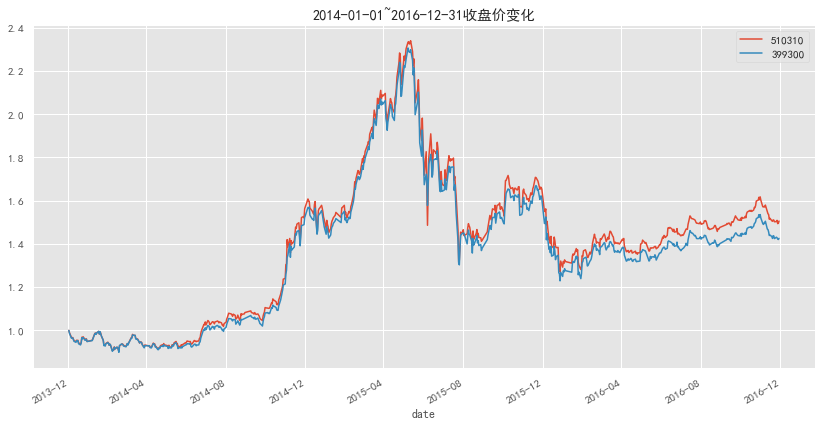

In [5]:
start = '2014-01-01'
end = '2016-12-31'
data = full_data[start:end]
data_benchmark = full_benchmark_data[start:end]
(data.close / data.iloc[0].close).plot(label=CODE)
(data_benchmark.close /
 data_benchmark.iloc[0].close).plot(label=BENCHMARK_CODE)
plt.legend()
plt.title('{}~{}收盘价变化'.format(start, end))

从上图可以看出 `510310` 与 `399300` 动作基本一致。所以以 `399300` 作为基准是可以的。

#### 按日期分组统计

In [6]:
market=calc_full_market(data)
market

收盘价变化率                    日价格变化幅度                   
           mean  median up_percent    mean  median up_percent
weekday                                                      
0        0.0005  0.0015     0.5385  0.0011  0.0015     0.5385
1        0.0004  0.0010     0.5133  0.0017  0.0010     0.5133
2        0.0006  0.0000     0.4467  0.0018  0.0003     0.5000
3        0.0008 -0.0013     0.4178  0.0014 -0.0011     0.4247
4        0.0015  0.0015     0.5417  0.0022  0.0017     0.5139

从以上表格中可以看出：

1. 根据`收盘价变化率-up_percent`列中的数据 -> 周三(2)、周四(3)的 `收盘价变化率` 低于50%，说明这两天的收盘价相对于前一个交易日时下跌的，由此可以认为在`2014-01-01~2016-12-31`期间，不应该在周三和周四持有股票；
2. 根据`日价格变化幅度-up-percent`列中的数据 -> 周四(3)的 `日价格变化幅度` 小于等于50%，说明这天更多的情况下开盘价会小于收盘价，也就是这两天更多可能性是下跌的。所以这两天如果需要买入的话应该在收盘时买入；

#### 完整测试

以下使用`2017-01-01~2017-12-31`间的数据进行测试

按照前面所说的规则，当`nextday`（下一个交易日）是否符合条件来确定买卖。

买入日期和买入方式的计算参考：https://github.com/GuQiangJS/gquant/blob/master/gquant/week_effect.py 中的 `calc_full_buy_dates` 和 `calc_full_buy_opens` 方法。

In [7]:
x = full_data['2017-01-01':'2017-12-31']
y = full_benchmark_data['2017-01-01':'2017-12-31']

buy_date_2017 = calc_full_buy_dates(market)
print('2017年买入日：{}'.format(buy_date_2017))
buy_open_2017 = calc_full_buy_opens(market)
print('2017年开盘买入日：{}'.format(buy_open_2017))

2017年买入日：[0 1 4]
2017年开盘买入日：[0 1 2 4]


按照前文所述，周四(3)如果要买入的话应该是收盘价买入，其他日期则是开盘价买入。

In [8]:
m_2017_report,m=full_test(x,y,buy_date_2017,buy_open_2017,name='2017完整')

244it [00:00, 1111.67it/s]


##### 结果

In [9]:
m_2017_report

,基准浮动盈亏(基准最后收盘/基准最先开盘),浮动盈亏(结算价值/初始资金),盈利次数,亏损次数,未结束交易购买金额,未结束交易当前价值,基准最大回撤,策略最大回撤
name,,,,,,,,
2017完整,1.2163,1.1691,32.0,16.0,11573.6,11614.4,-0.0627,-0.0326


从上表可以看出，策略将最大回撤降低了50%，并且盈利次数是亏损次数的1倍（从心理上来说也较为容易接受一点）。但是**浮动盈亏未能跑赢基准**。

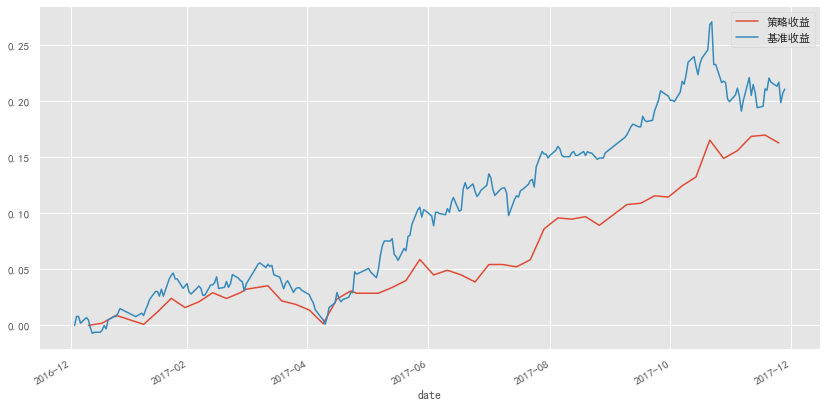

In [10]:
m.plot_cash()

#### 上涨/下跌市分开测试

##### 拆分市场

按照 **昨日市场状态(昨日收盘价是否超过20日均线)** 来区分上涨市/下跌市

In [11]:
market_split=calc_split_market(data)
market_split

收盘价变化率                        日价格变化幅度                   
                       mean  median up_percent        mean  median up_percent
prev_market weekday                                                          
-1.0        0       -0.0019 -0.0013     0.4286 -1.5964e-03 -0.0009     0.4464
            1        0.0023  0.0036     0.6271  4.2293e-03  0.0035     0.6102
            2        0.0014  0.0004     0.5000  3.1176e-03  0.0011     0.5345
            3       -0.0022 -0.0015     0.3962 -2.4385e-04 -0.0016     0.3774
            4        0.0004  0.0000     0.4815  1.8798e-03 -0.0003     0.4815
 1.0        0        0.0020  0.0031     0.6092  2.7805e-03  0.0023     0.5977
            1       -0.0009 -0.0012     0.4396 -5.3366e-06  0.0000     0.4505
            2        0.0001 -0.0009     0.4130  1.0271e-03  0.0000     0.4783
            3        0.0025 -0.0010     0.4301  2.3743e-03 -0.0010     0.4516
            4        0.0022  0.0018     0.5778  2.3995e-03  0.0021     0.5333

从上表可知：

* 买入/卖出规则：

    1. 下跌市(prev_market=-1)：只有周二(1)、周三(2)的收盘价变化率（当日收盘价>前日收盘价的百分比）大于等于50%并且变化率中位数大于0，也就是说**对于2014~2016的下跌市来说只有周二(1)、周三(2)才能持有/买入**；
    2. 上涨市(prev_market=1): 只有周一(0)、周五(4)的收盘价变化率达到或超过了50%（50%时的变化率中位数为正数，所以也有机会盈利），也就是说**对于2014~2016的上涨市来说只有周一(0)、周五(4)能持有/买入**；
    
* 价格规则：

    1. 下跌市(-1)：除周二(1)、周三(2)外的日价格变化幅度均小于50%并且中位数小于0，说明当天开盘价高于收盘价；
        * 买入：
            * 开盘价：周二(1)、周三(2)
            * 收盘价：周一(0)、周四(3)、周五(4)
        * 卖出(与买入相反)
    2. 上涨市(1): 除周一(0)、周五(4)外的日价格变化幅度均小于50%并且中位数小于0，说明当天开盘价高于收盘价；
        * 买入：
            * 开盘价：周一(0)、周五(4)
            * 收盘价：周二(1)、周三(2)、周四(3)
        * 卖出(与买入相反)
        
---

##### 上涨市/下跌市判断规则
        
**增加上涨市/下跌市判断时，需要注意应该判断的条件如下：**
1. 是否为上涨/下跌应该取`prev_market`(昨天为上涨或下跌，因为今天还没开始，并且需要在今天进行操作)
2. `nextday`(明天)为周几

---

##### 计算不同市场下的买卖日期

根据`收盘价变化率`来确定指定日期是否可以买入（`up_percent`超过0.5时表示当日收盘价>前日收盘价的可能性超过50%）。如果是0.5的话，增加判断`median`（`当日收盘价/前日收盘价-1`后的中位数，如果大于零说明虽然只有一半的天数是上涨，但是上涨幅度大于下跌幅度）

实现参考：https://github.com/GuQiangJS/gquant/blob/master/gquant/week_effect.py 中的 `calc_split_buy_dates` 方法。

##### 计算不同市场下的买入方式：

根据`日价格变化幅度`来确定指定日期是开盘价买入还是收盘价买入（`up_percent`超过0.5时表示当日收盘价>当日开盘价的可能性超过50%）。如果是0.5的话，增加判断`median`（`当日收盘价/当日收盘价-1`后的中位数，如果大于零说明虽然只有一半的天数是上涨，但是上涨幅度大于下跌幅度）

实现参考：https://github.com/GuQiangJS/gquant/blob/master/gquant/week_effect.py 中的 `calc_full_buy_opens` 方法。

计算出开盘买入的集合后：

1. 取反后的集合就是收盘买入的部分；
2. 卖出时日期部分相同，但是取开盘价和收盘价时刚好相反；

In [12]:
low_buy_dates,up_buy_dates=calc_split_buy_dates(market_split)
low_buy_open,up_buy_open=calc_split_buy_opens(market_split)
print('下跌市买入日：{}'.format(low_buy_dates))
print('下跌市开盘买入日期：{}'.format(low_buy_open))
print('上涨市买入日：{}'.format(up_buy_dates))
print('上涨市开盘买入日期：{}'.format(up_buy_open))

下跌市买入日：[1 2]
下跌市开盘买入日期：[1 2]
上涨市买入日：[0 4]
上涨市开盘买入日期：[0 4]


In [13]:
x = full_data['2017-01-01':'2017-12-31']
y = full_benchmark_data['2017-01-01':'2017-12-31']
m_2017_split_report,m=split_test(x,y,low_buy_dates,up_buy_dates,low_buy_open,up_buy_open,'2017拆分')

244it [00:00, 973.91it/s]


##### 结果

In [14]:
pd.concat([m_2017_report,m_2017_split_report])

,基准浮动盈亏(基准最后收盘/基准最先开盘),浮动盈亏(结算价值/初始资金),盈利次数,亏损次数,未结束交易购买金额,未结束交易当前价值,基准最大回撤,策略最大回撤
name,,,,,,,,
2017完整,1.2163,1.1691,32.0,16.0,11573.6,11614.4,-0.0627,-0.0326
2017拆分,1.2163,1.1069,30.0,21.0,10854.4,10931.2,-0.0627,-0.0219


~~🎉   干的漂亮！！！区分了上涨市/下跌市后，区分不同的买入/卖出策略后竟然**跑赢了基准**(从`1.1691`上升到`1.2517`)，但是最大回撤却增大了1%(从`-0.0326`下降到`-0.0497`)。~~

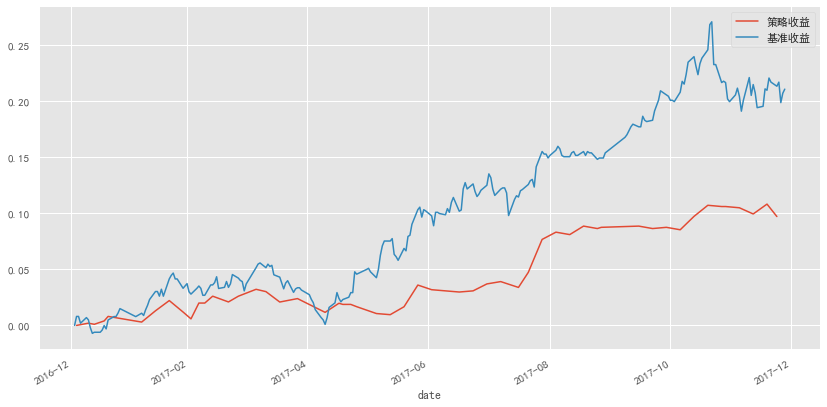

In [15]:
m.plot_cash()

### 2015~2017 -> 2018

In [16]:
data=full_data['2015-01-01':'2017-12-31']
x = full_data['2018-01-01':'2018-12-31']
y = full_benchmark_data['2018-01-01':'2018-12-31']

#### 按日期分组统计

In [17]:
market=calc_full_market(data)
market

收盘价变化率                    日价格变化幅度                   
           mean  median up_percent    mean  median up_percent
weekday                                                      
0        0.0007  0.0025     0.5704  0.0012  0.0023     0.5634
1        0.0006  0.0014     0.5405  0.0018  0.0015     0.5405
2       -0.0001 -0.0007     0.4667  0.0011  0.0006     0.5067
3        0.0002  0.0000     0.4694  0.0010  0.0006     0.5034
4        0.0007  0.0012     0.5241  0.0015  0.0012     0.5241

In [18]:
buy_dates=calc_full_buy_dates(market)
print('根据2015~2017间的数据预判,2018年合适的买入日：{}'.format(buy_dates))

buy_opens=calc_full_buy_opens(market)
print('根据2015~2017间的数据预判,2018年合适的开盘买入日：{}'.format(buy_opens))

根据2015~2017间的数据预判,2018年合适的买入日：[0 1 4]
根据2015~2017间的数据预判,2018年合适的开盘买入日：[0 1 2 3 4]


In [19]:
m_2018_report,m=full_test(x,y,buy_dates,buy_opens,name='2018完整')

243it [00:00, 526.74it/s]


##### 结果

In [20]:
m_2018_report

,基准浮动盈亏(基准最后收盘/基准最先开盘),浮动盈亏(结算价值/初始资金),盈利次数,亏损次数,未结束交易购买金额,未结束交易当前价值,基准最大回撤,策略最大回撤
name,,,,,,,,
2018完整,0.7443,0.9352,27.0,23.0,0.0,0.0,-0.3167,-0.1431


2018年整体处于下跌趋势，基准下跌了`25%`，策略只下跌了`7%`。

Text(0.5, 1.0, '2018年')

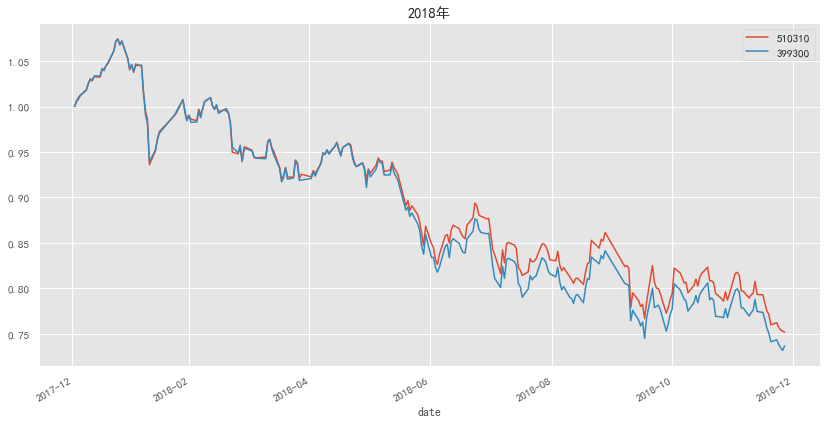

In [21]:
(x.close/x.close.iloc[0]).plot(label=CODE)
(y.close/y.close.iloc[0]).plot(label=BENCHMARK_CODE)
plt.legend()
plt.title('2018年')

#### 上涨市/下跌市分开测试

In [22]:
market_split=calc_split_market(data)
market_split

收盘价变化率                    日价格变化幅度                   
                       mean  median up_percent    mean  median up_percent
prev_market weekday                                                      
-1.0        0       -0.0005  0.0010     0.5370 -0.0003  0.0023     0.5556
            1        0.0024  0.0035     0.6481  0.0043  0.0023     0.5926
            2        0.0006  0.0008     0.5094  0.0024  0.0006     0.5094
            3       -0.0021 -0.0011     0.4375  0.0002 -0.0007     0.4792
            4        0.0004  0.0011     0.5192  0.0018  0.0018     0.5385
 1.0        0        0.0014  0.0027     0.5909  0.0022  0.0023     0.5682
            1       -0.0005  0.0000     0.4787  0.0004  0.0007     0.5106
            2       -0.0005 -0.0007     0.4433  0.0005  0.0006     0.5052
            3        0.0013  0.0000     0.4848  0.0014  0.0012     0.5152
            4        0.0009  0.0012     0.5269  0.0013  0.0006     0.5161

根据[规则](#%E8%AE%A1%E7%AE%97%E4%B8%8D%E5%90%8C%E5%B8%82%E5%9C%BA%E4%B8%8B%E7%9A%84%E4%B9%B0%E5%8D%96%E6%97%A5%E6%9C%9F)来判断买入日期

In [23]:
low_buy_dates,up_buy_dates=calc_split_buy_dates(market_split)
low_buy_open,up_buy_open=calc_split_buy_opens(market_split)
print('下跌市买入日：{}'.format(low_buy_dates))
print('下跌市开盘买入日期：{}'.format(low_buy_open))
print('上涨市买入日：{}'.format(up_buy_dates))
print('上涨市开盘买入日期：{}'.format(up_buy_open))

下跌市买入日：[0 1 2 4]
下跌市开盘买入日期：[0 1 2 4]
上涨市买入日：[0 4]
上涨市开盘买入日期：[0 1 2 3 4]


In [24]:
m_2018_split_report,m=split_test(x,y,low_buy_dates,up_buy_dates,low_buy_open,up_buy_open,'2018拆分')

243it [00:00, 1046.32it/s]


##### 结果

In [25]:
pd.concat([m_2018_report,m_2018_split_report])

,基准浮动盈亏(基准最后收盘/基准最先开盘),浮动盈亏(结算价值/初始资金),盈利次数,亏损次数,未结束交易购买金额,未结束交易当前价值,基准最大回撤,策略最大回撤
name,,,,,,,,
2018完整,0.7443,0.9352,27.0,23.0,0.0,0.0,-0.3167,-0.1431
2018拆分,0.7443,1.0088,27.0,25.0,0.0,0.0,-0.3167,-0.1133


🎉  给我惊喜！！！区分了上涨市/下跌市后，区分不同的买入/卖出策略后竟然**不但跑赢基准，竟然还盈利了**(从`0.7443`上升到`1.0088`)，并且最大回撤也下降了50%以上(从`-0.3167`下降到`-0.1133`)。

### 2016~2018 -> 2019

In [26]:
data=full_data['2016-01-01':'2018-12-31']
x = full_data['2019-01-01':'2019-12-31']
y = full_benchmark_data['2019-01-01':'2019-12-31']

#### 按日期分组统计

In [27]:
market=calc_full_market(data)
market

收盘价变化率                    日价格变化幅度                   
           mean  median up_percent    mean  median up_percent
weekday                                                      
0       -0.0001  0.0012     0.5357 -0.0004  0.0015     0.5357
1        0.0015  0.0014     0.5510  0.0015  0.0014     0.5374
2       -0.0012 -0.0015     0.4067 -0.0007 -0.0007     0.4333
3       -0.0015 -0.0007     0.4354 -0.0010 -0.0007     0.4626
4        0.0006  0.0007     0.5102  0.0011  0.0000     0.4898

In [28]:
buy_dates=calc_full_buy_dates(market)
print('根据2016~2018间的数据预判,2019年合适的买入日：{}'.format(buy_dates))

buy_opens=calc_full_buy_opens(market)
print('根据2016~2018间的数据预判,2019年合适的开盘买入日：{}'.format(buy_opens))

根据2016~2018间的数据预判,2019年合适的买入日：[0 1 4]
根据2016~2018间的数据预判,2019年合适的开盘买入日：[0 1]


In [29]:
m_2019_report,m=full_test(x,y,buy_dates,buy_opens,name='2019完整')

244it [00:00, 1097.09it/s]


##### 结果

In [30]:
m_2019_report

,基准浮动盈亏(基准最后收盘/基准最先开盘),浮动盈亏(结算价值/初始资金),盈利次数,亏损次数,未结束交易购买金额,未结束交易当前价值,基准最大回撤,策略最大回撤
name,,,,,,,,
2019完整,1.3578,1.3653,30.0,19.0,0.0,0.0,-0.1311,-0.0797


#### 上涨市/下跌市分开测试

In [31]:
market_split=calc_split_market(data)
market_split

收盘价变化率                    日价格变化幅度                   
                           mean  median up_percent    mean  median up_percent
prev_market weekday                                                          
-1.0        0       -3.0781e-04  0.0010     0.5303 -0.0007  0.0019     0.5606
            1        2.5159e-03  0.0023     0.6154  0.0016  0.0014     0.5538
            2       -2.1084e-03 -0.0029     0.3750 -0.0019 -0.0023     0.3594
            3       -2.1266e-03 -0.0007     0.4355 -0.0006 -0.0004     0.4839
            4        6.0788e-04  0.0007     0.5217  0.0015 -0.0006     0.4783
 1.0        0        3.1979e-05  0.0013     0.5405 -0.0002  0.0011     0.5135
            1        7.2408e-04  0.0003     0.5000  0.0015  0.0012     0.5244
            2       -4.7171e-04 -0.0007     0.4302  0.0001  0.0000     0.4884
            3       -1.0608e-03  0.0000     0.4353 -0.0013 -0.0007     0.4471
            4        5.4915e-04  0.0006     0.5000  0.0007  0.0003     0.5000

根据[规则](#%E8%AE%A1%E7%AE%97%E4%B8%8D%E5%90%8C%E5%B8%82%E5%9C%BA%E4%B8%8B%E7%9A%84%E4%B9%B0%E5%8D%96%E6%97%A5%E6%9C%9F)来判断买入日期

In [32]:
low_buy_dates,up_buy_dates=calc_split_buy_dates(market_split)
low_buy_open,up_buy_open=calc_split_buy_opens(market_split)
print('下跌市买入日：{}'.format(low_buy_dates))
print('下跌市开盘买入日期：{}'.format(low_buy_open))
print('上涨市买入日：{}'.format(up_buy_dates))
print('上涨市开盘买入日期：{}'.format(up_buy_open))

下跌市买入日：[0 1 4]
下跌市开盘买入日期：[0 1]
上涨市买入日：[0 1 4]
上涨市开盘买入日期：[0 1 4]


In [33]:
m_2019_split_report,m=split_test(x,y,low_buy_dates,up_buy_dates,low_buy_open,up_buy_open,'2019拆分')

244it [00:00, 981.64it/s] 


##### 结果

In [34]:
pd.concat([m_2019_report,m_2019_split_report])

,基准浮动盈亏(基准最后收盘/基准最先开盘),浮动盈亏(结算价值/初始资金),盈利次数,亏损次数,未结束交易购买金额,未结束交易当前价值,基准最大回撤,策略最大回撤
name,,,,,,,,
2019完整,1.3578,1.3653,30.0,19.0,0.0,0.0,-0.1311,-0.0797
2019拆分,1.3578,1.3653,30.0,19.0,0.0,0.0,-0.1311,-0.0797


依然与前面的测试结果一致，区分了上涨市和下跌市后，盈利近一步增加。跑赢基准。

### 2017~2019 -> 2020

In [35]:
data=full_data['2017-01-01':'2019-12-31']
x = full_data['2020-01-01':'2020-12-31']
y = full_benchmark_data['2020-01-01':'2020-12-31']

#### 按日期分组统计

In [36]:
market=calc_full_market(data)
market

收盘价变化率                    日价格变化幅度                   
           mean  median up_percent    mean  median up_percent
weekday                                                      
0        0.0017  0.0019     0.5704  0.0007  0.0012     0.5423
1        0.0012  0.0014     0.5510  0.0013  0.0017     0.5578
2       -0.0012 -0.0012     0.3893 -0.0012 -0.0014     0.3960
3       -0.0008 -0.0007     0.4257 -0.0004  0.0000     0.4595
4        0.0014  0.0014     0.5517  0.0014  0.0014     0.5586

In [37]:
buy_dates=calc_full_buy_dates(market)
print('根据2017~2019间的数据预判,2019年合适的买入日：{}'.format(buy_dates))

buy_opens=calc_full_buy_opens(market)
print('根据2016~2018间的数据预判,2019年合适的开盘买入日：{}'.format(buy_opens))

根据2017~2019间的数据预判,2019年合适的买入日：[0 1 4]
根据2016~2018间的数据预判,2019年合适的开盘买入日：[0 1 4]


In [38]:
m_2020_report,m=full_test(x,y,buy_dates,buy_opens,name='2020完整')

243it [00:00, 1120.34it/s]


##### 结果

In [39]:
m_2020_report

,基准浮动盈亏(基准最后收盘/基准最先开盘),浮动盈亏(结算价值/初始资金),盈利次数,亏损次数,未结束交易购买金额,未结束交易当前价值,基准最大回撤,策略最大回撤
name,,,,,,,,
2020完整,1.2645,1.2167,31.0,18.0,12076.8,12076.8,-0.1622,-0.1287


#### 上涨市/下跌市分开测试

In [40]:
market_split=calc_split_market(data)
market_split

收盘价变化率                        日价格变化幅度                   
                       mean  median up_percent        mean  median up_percent
prev_market weekday                                                          
-1.0        0        0.0010  0.0019     0.5738 -9.4777e-05  0.0018     0.5738
            1        0.0017  0.0027     0.6000  1.6308e-03  0.0024     0.6000
            2       -0.0021 -0.0025     0.3729 -2.1266e-03 -0.0023     0.3390
            3       -0.0015 -0.0008     0.3934 -4.4654e-04  0.0000     0.4590
            4        0.0015  0.0013     0.5441  1.2905e-03  0.0014     0.5294
 1.0        0        0.0022  0.0012     0.5679  1.2573e-03  0.0006     0.5185
            1        0.0008  0.0007     0.5172  1.0687e-03  0.0012     0.5287
            2       -0.0006 -0.0010     0.4000 -5.5854e-04 -0.0009     0.4333
            3       -0.0004  0.0000     0.4483 -3.2512e-04  0.0000     0.4598
            4        0.0013  0.0017     0.5584  1.5528e-03  0.0012     0.5844

根据[规则](#%E8%AE%A1%E7%AE%97%E4%B8%8D%E5%90%8C%E5%B8%82%E5%9C%BA%E4%B8%8B%E7%9A%84%E4%B9%B0%E5%8D%96%E6%97%A5%E6%9C%9F)来判断买入日期

In [41]:
low_buy_dates,up_buy_dates=calc_split_buy_dates(market_split)
low_buy_open,up_buy_open=calc_split_buy_opens(market_split)
print('下跌市买入日：{}'.format(low_buy_dates))
print('下跌市开盘买入日期：{}'.format(low_buy_open))
print('上涨市买入日：{}'.format(up_buy_dates))
print('上涨市开盘买入日期：{}'.format(up_buy_open))

下跌市买入日：[0 1 4]
下跌市开盘买入日期：[0 1 4]
上涨市买入日：[0 1 4]
上涨市开盘买入日期：[0 1 4]


In [42]:
m_2020_split_report,m=split_test(x,y,low_buy_dates,up_buy_dates,low_buy_open,up_buy_open,'2020拆分')

243it [00:00, 1098.11it/s]


##### 结果

In [43]:
pd.concat([m_2020_report,m_2020_split_report])

,基准浮动盈亏(基准最后收盘/基准最先开盘),浮动盈亏(结算价值/初始资金),盈利次数,亏损次数,未结束交易购买金额,未结束交易当前价值,基准最大回撤,策略最大回撤
name,,,,,,,,
2020完整,1.2645,1.2167,31.0,18.0,12076.8,12076.8,-0.1622,-0.1287
2020拆分,1.2645,1.2167,31.0,18.0,12076.8,12076.8,-0.1622,-0.1287


依然与前面的测试结果一致，区分了上涨市和下跌市后，盈利近一步增加。跑赢基准。

## 合并总结

从下表看，除2017年稍稍落后于基准外，其他三个年份均超过基准。其中2018年拆分后竟然由亏损变为盈利，实在是让人惊喜。并且从每年的盈利/亏损次数比率来看，也是盈利次数较多，这可以获得心理上的胜利感。

In [44]:
report=pd.concat([
    m_2017_report, m_2017_split_report, m_2018_report, m_2018_split_report,
    m_2019_report, m_2019_split_report, m_2020_report, m_2020_split_report
]).rename(columns={
    '基准浮动盈亏(基准最后收盘/基准最先开盘)': '基准浮动盈亏',
    '浮动盈亏(结算价值/初始资金)': '策略浮动盈亏'
})
report['跑赢基准']=report['策略浮动盈亏']/report['基准浮动盈亏']-1
report.style.bar(subset=['跑赢基准'], align='mid', color=['#5fba7d','#d65f5f'])

,基准浮动盈亏,策略浮动盈亏,盈利次数,亏损次数,未结束交易购买金额,未结束交易当前价值,基准最大回撤,策略最大回撤,跑赢基准
name,,,,,,,,,
2017完整,1.2163,1.1691,32.0000,16.0000,11573.6000,11614.4000,-0.0627,-0.0326,-0.0389
2017拆分,1.2163,1.1069,30.0000,21.0000,10854.4000,10931.2000,-0.0627,-0.0219,-0.0900
2018完整,0.7443,0.9352,27.0000,23.0000,0.0000,0.0000,-0.3167,-0.1431,0.2566
2018拆分,0.7443,1.0088,27.0000,25.0000,0.0000,0.0000,-0.3167,-0.1133,0.3555
2019完整,1.3578,1.3653,30.0000,19.0000,0.0000,0.0000,-0.1311,-0.0797,0.0055
2019拆分,1.3578,1.3653,30.0000,19.0000,0.0000,0.0000,-0.1311,-0.0797,0.0055
2020完整,1.2645,1.2167,31.0000,18.0000,12076.8000,12076.8000,-0.1622,-0.1287,-0.0378
2020拆分,1.2645,1.2167,31.0000,18.0000,12076.8000,12076.8000,-0.1622,-0.1287,-0.0378


## 蒙特卡洛模拟

前面只是测试了取前3年的数据作为测算数据，后一年的数据作为验证数据，并且均是从01-01至12-31日。从实际来说不太可能这么巧，所以以下从`2015-01-01~2019-12-31`之间随机选择一个日期，向前推`1~3`年（随机选择）作为测算数据，向后推`93天~366天`(随机选择，3个月到一年）。对数据进行蒙特卡洛模拟测算。*用来模拟测算随机日期是否能够跑赢基准*。

In [14]:
from matplotlib.gridspec import GridSpec
from itertools import product
def report_plot(report):
    # https://matplotlib.org/stable/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py
    pie_colors=['orangered','silver']
    
    def _plot_pie(data,ax,title):
        data.value_counts().plot(kind='pie',ax=ax,autopct='%1.2f%%',label='',colors=pie_colors,textprops={'color':'w','size':14,'name':'reithsans'})
        ax.set_title(title)
    def _plot_kde(data,ax,title):
        sns.distplot(data,ax=ax)
        ax.set_title(title,size=12)
    
    def _plot_regplot(data,ax,title):
        lm=sns.regplot(data=report[(report.index==v)], x="test_days", y="策略-基准盈亏",ax=ax,color='silver',line_kws={'color':'orangered'})
        ax.set_title(title)
    
    fig = plt.figure(figsize=(16,24),constrained_layout=True)
    gs = GridSpec(8, 4, figure=fig)
    
    report['策略-基准盈亏']=report['策略浮动盈亏']-report['基准浮动盈亏']
    for i,index in enumerate(list(product(['跑赢基准','是否盈利'],['完整','拆分']))):
        _plot_pie(report.loc[index[1],index[0]],fig.add_subplot(gs[i, 0]),'{}-{}'.format(index[0],index[1]))
        for j,year in enumerate([1,2,3]):
            _plot_pie(report[(report.index==index[1])&(report.passyears==year)][index[0]],fig.add_subplot(gs[i, j+1]),'{}-{}-{}年'.format(index[0],index[1],year))
    
    for i,v in enumerate(['完整','拆分']):
        _plot_kde(report[(report.index==v)]['策略-基准盈亏'],fig.add_subplot(gs[4+i, 0]),'策略-基准盈亏-{}-统算'.format(v))
        for j,y in enumerate([1,2,3]):
            _plot_kde(report[(report.index==v)&(report.passyears==y)]['策略-基准盈亏'],fig.add_subplot(gs[4+i, 1+j]),'策略-基准盈亏-{}-{}年'.format(v,y))
            
    for i,v in enumerate(['完整','拆分']):
        _plot_regplot(report[(report.index==v)]['策略-基准盈亏'],fig.add_subplot(gs[6+i, 0]),'策略-基准盈亏-{}-统算'.format(v))
        for j,y in enumerate([1,2,3]):
            _plot_regplot(report[(report.index==v)&(report.passyears==y)]['策略-基准盈亏'],fig.add_subplot(gs[6+i, 1+j]),'策略-基准盈亏-{}-{}年'.format(v,y))
            
            
    fig.suptitle('{}次循环'.format(report.shape[0]/2),size='20')
    plt.show()

full_data = get_data(CODE, START, END)
full_benchmark_data = get_data(BENCHMARK_CODE, START, END)

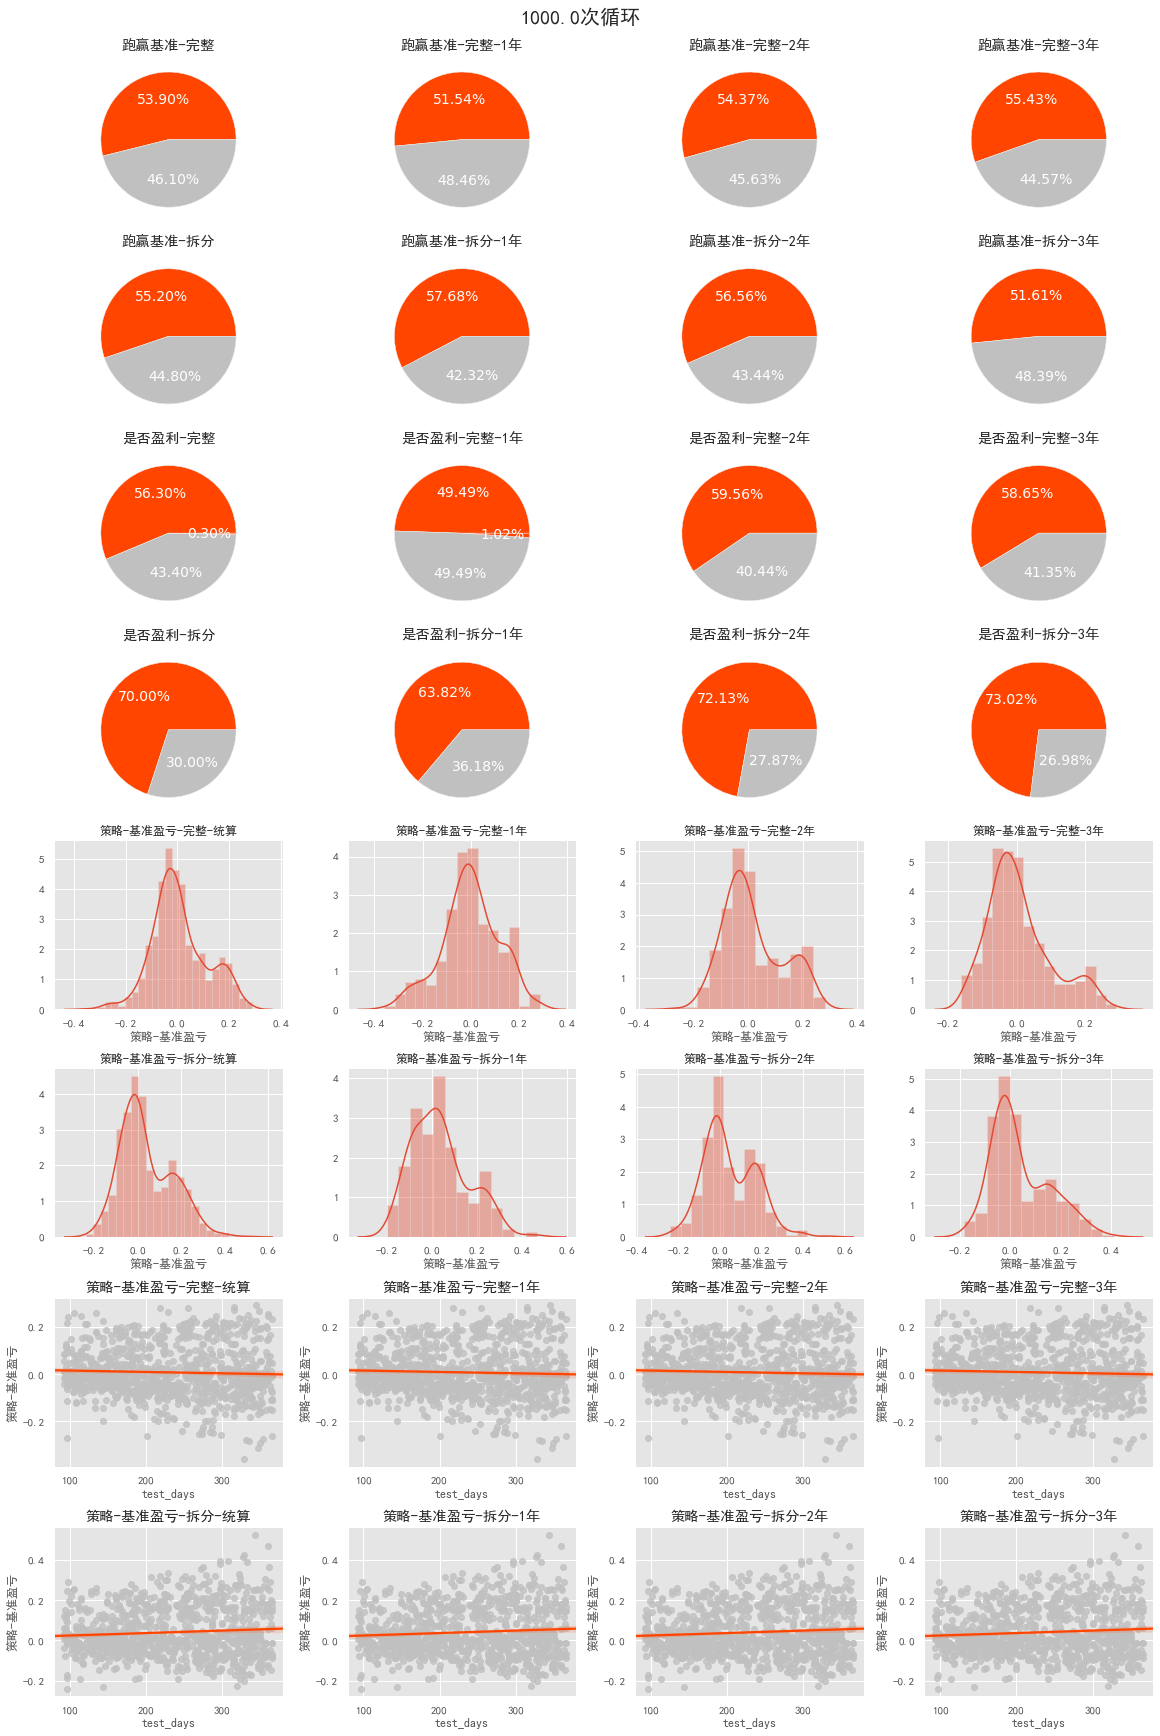

In [7]:
report_1000 = MonteCarloTest(full_data, full_benchmark_data,times=1000,multiprocessing=True)
from IPython.display import clear_output
clear_output(wait=True)
report_plot(report_1000)

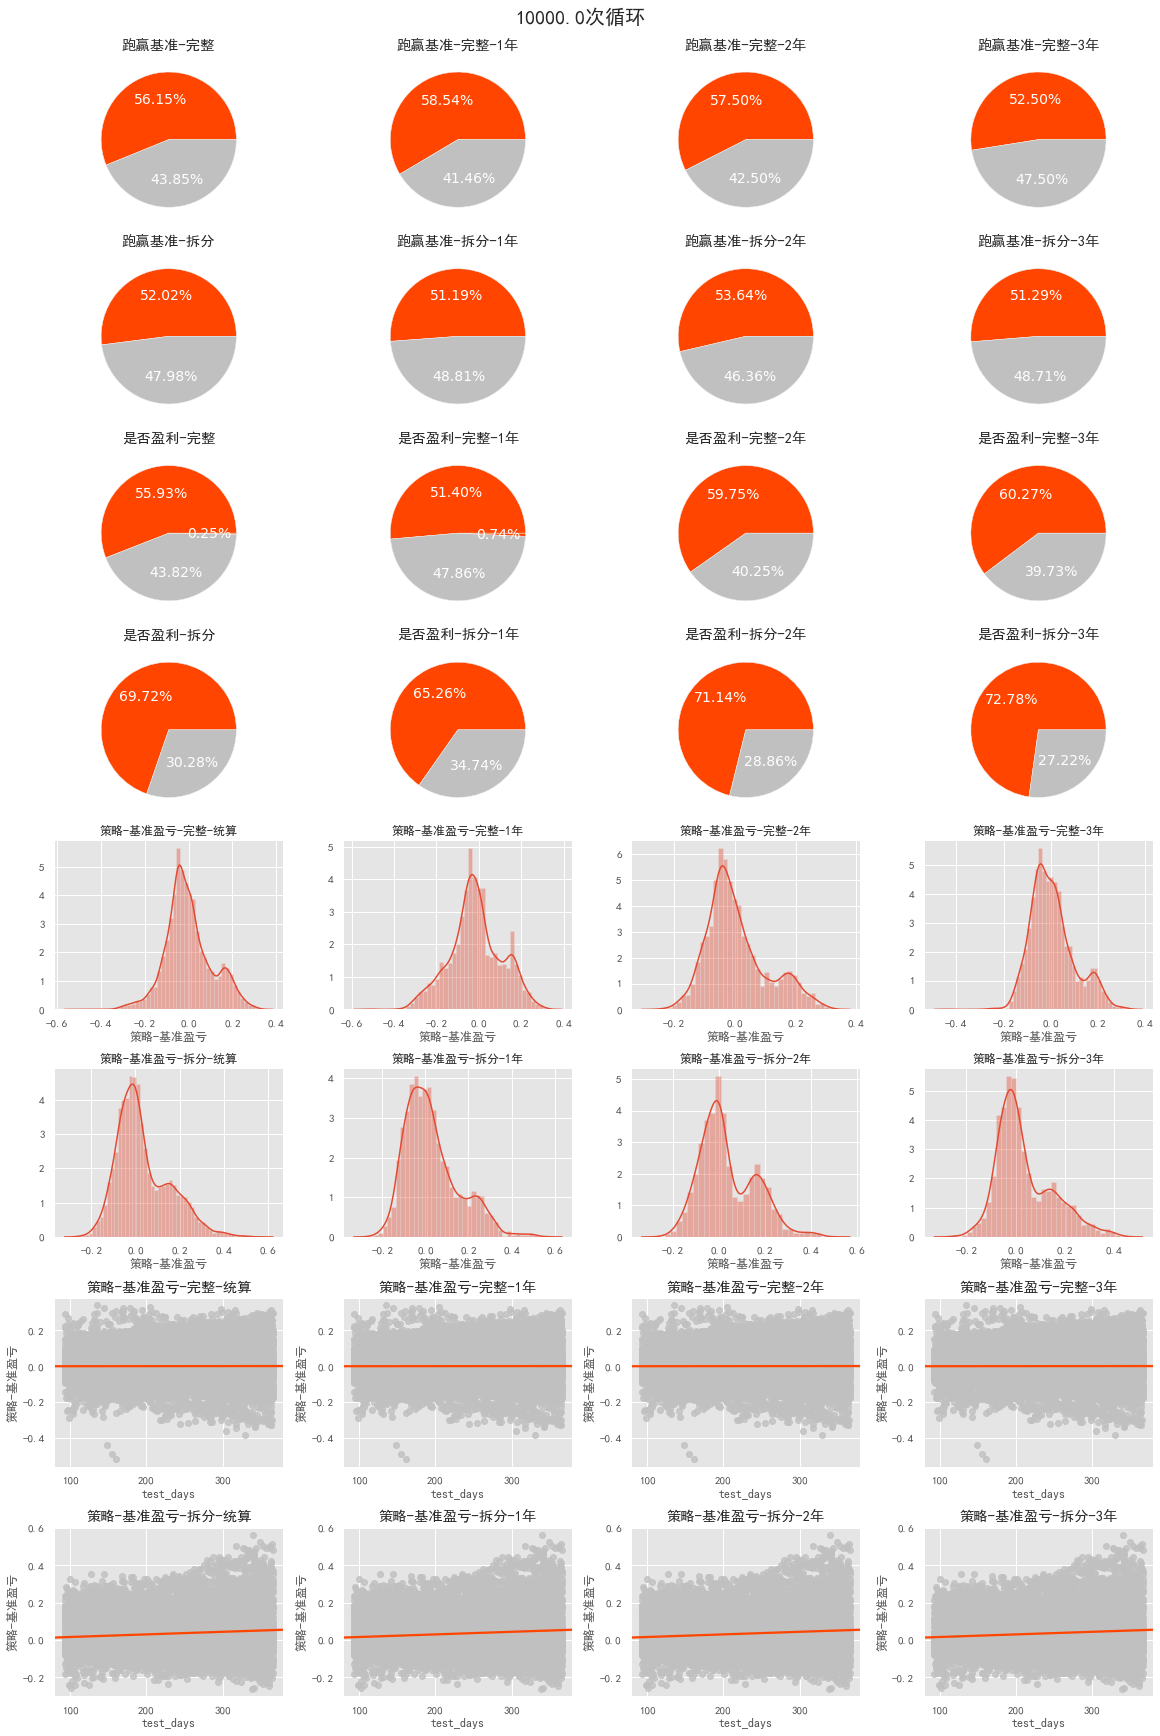

In [8]:
report_10000 = MonteCarloTest(full_data, full_benchmark_data,times=10000,multiprocessing=True)
from IPython.display import clear_output
clear_output(wait=True)
report_plot(report_10000)

findfont: Font family ['reithsans'] not found. Falling back to DejaVu Sans.
QUANTAXIS>> findfont: Font family ['reithsans'] not found. Falling back to DejaVu Sans.


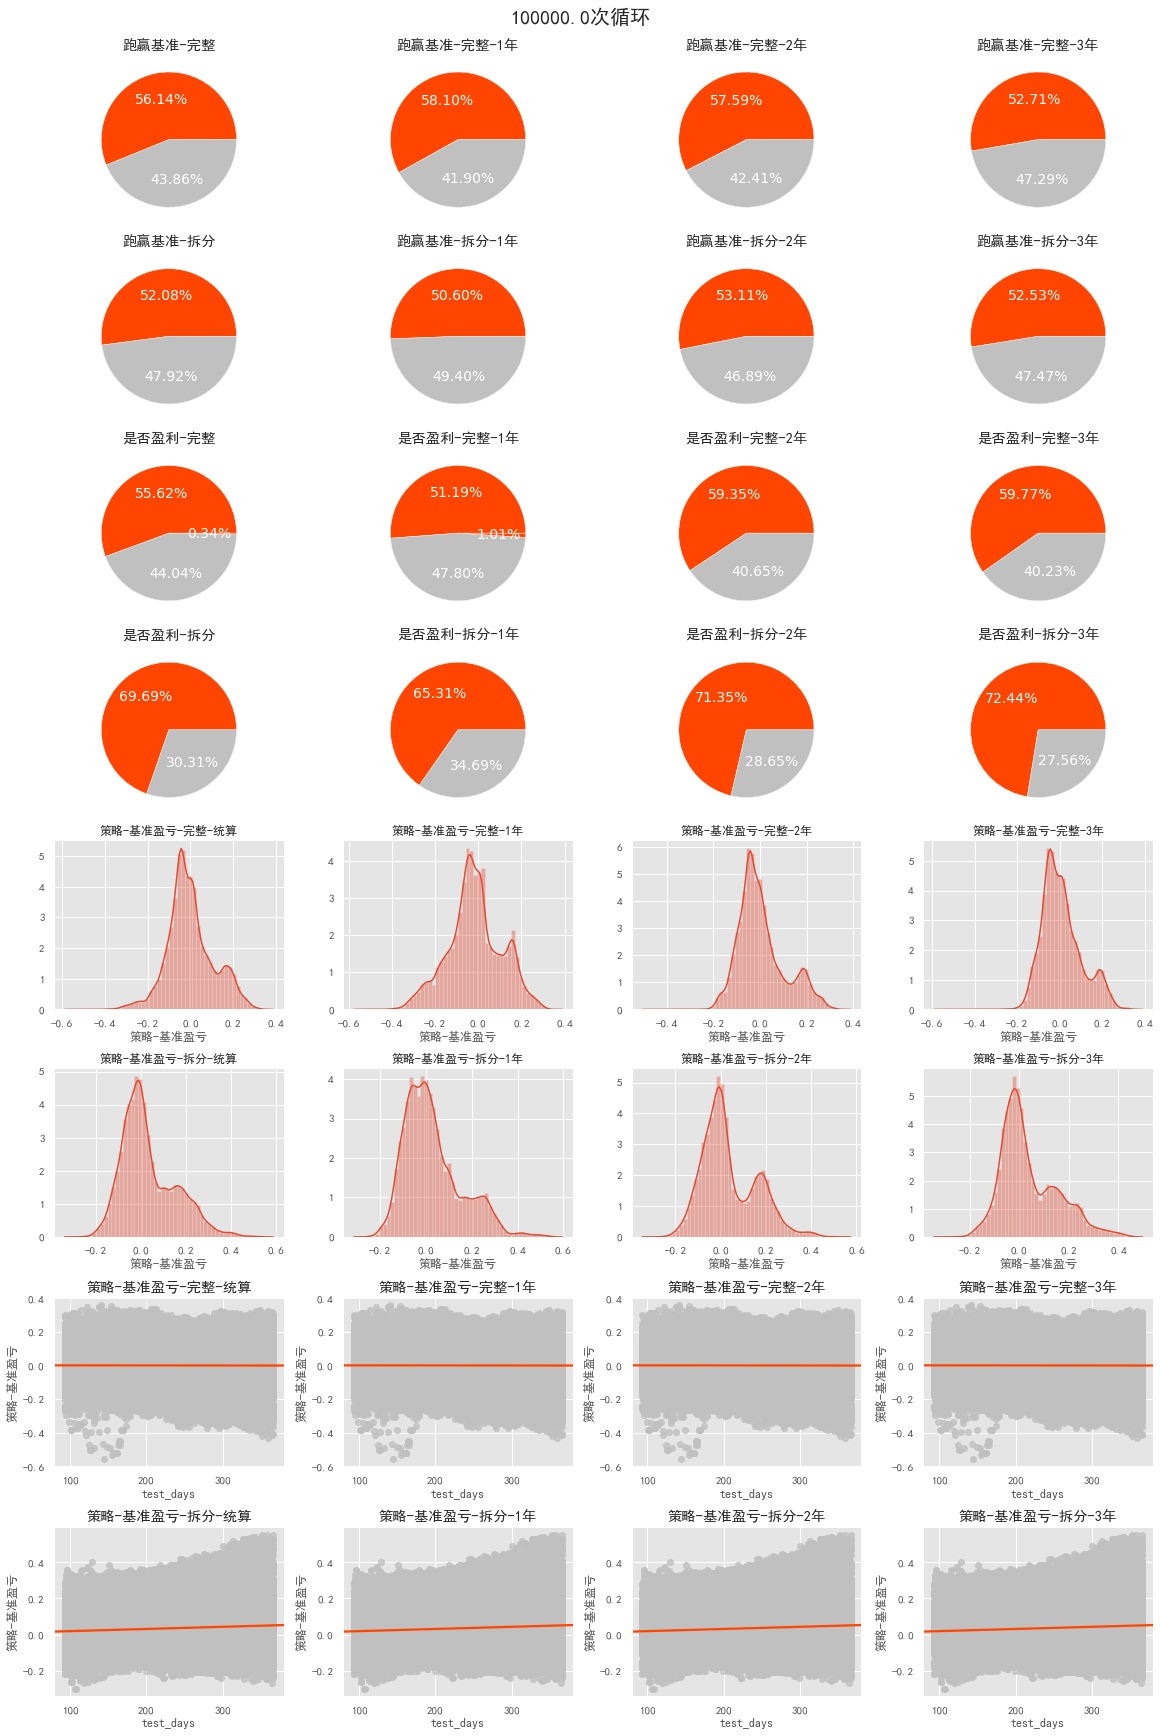

In [5]:
report_100000 = MonteCarloTest(full_data, full_benchmark_data,times=100000,multiprocessing=True)
from IPython.display import clear_output
clear_output(wait=True)
report_plot(report_100000)

### 100万次

拆分上涨市/下跌市时:

* 策略收益平均比基准收益 多`5.81%`，中位数为 `9.24%`;

* 最大回撤中位数由基准的 `20.07%` 下降至 `7.73%` 也低于未拆分时的 `8.93%`。

* 随着回看年数的增加，跑赢基准的次数也会增加；拆分的跑赢百分比明显比非拆分高，回看三年时高出`18%`;

> 数据来源：通过脚本执行的结果，保存在`Result_510310.7z`中，解压缩后使用。

In [ ]:
import os
report_1000000 = pd.concat([pd.read_csv(f) for f in os.listdir() if 'Result_510310' in f]).set_index('name').drop_duplicates()

In [22]:
report_1000000.head(1)

,基准浮动盈亏,策略浮动盈亏,盈利次数,亏损次数,未结束交易购买金额,未结束交易当前价值,基准最大回撤,策略最大回撤,x_start,x_end,y_start,y_end,passyears,test_days,跑赢基准,是否盈利,策略-基准盈亏
name,,,,,,,,,,,,,,,,,
完整,0.899,1.0464,14.0,7.0,10512.0,10454.4,-0.1338,-0.0326,2014-12-26,2016-12-24,2016-12-25,2017-06-05,2,162,1.0,1.0,0.1475


In [19]:
report_1000000.groupby('name')['策略-基准盈亏'].describe()

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
完整,967335.0,-0.0007,0.2103,-1.7465,-0.0851,0.0430,0.1350,0.4641
拆分,874177.0,0.0581,0.1973,-1.4767,-0.0125,0.0924,0.1828,0.4885


In [27]:
report_1000000.groupby('name')['基准最大回撤','策略最大回撤'].agg(['mean','median'])

基准最大回撤          策略最大回撤        
        mean  median    mean  median
name                                
完整   -0.2334 -0.2007 -0.1146 -0.0893
拆分   -0.2404 -0.2007 -0.0878 -0.0773

In [87]:
import matplotlib.ticker as mtick
win_rate = report_1000000.groupby(
    ['name', 'passyears'])['跑赢基准'].value_counts(normalize=True).to_frame()
win_rate = win_rate[win_rate.index.get_level_values(2) == 1]
win_rate.index = win_rate.index.droplevel(2)
win_rate

跑赢基准
name passyears        
完整   1          0.5814
     2          0.5977
     3          0.6250
拆分   1          0.6828
     2          0.7060
     3          0.8039

Text(0.5, 1.0, '拆分/完整 跑赢基准的可能性')

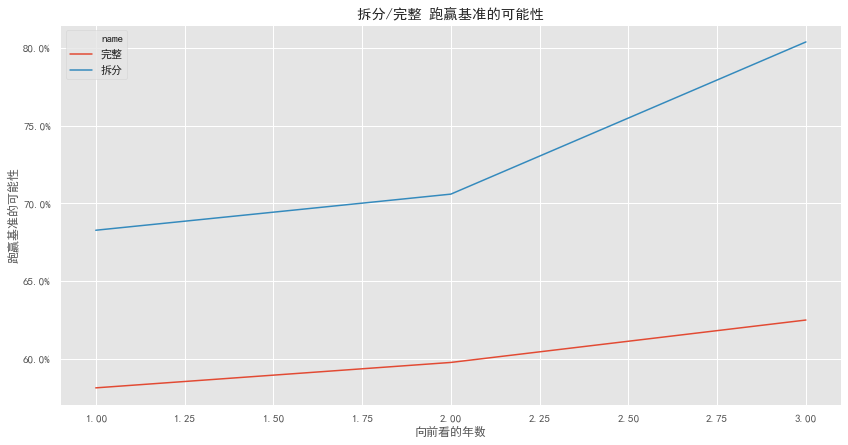

In [88]:
win_rate.reset_index(inplace=True)
ax = sns.lineplot(data=win_rate, x="passyears", y="跑赢基准", hue="name")
ax.set_ylabel('跑赢基准的可能性')
ax.set_xlabel('向前看的年数')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.title("拆分/完整 跑赢基准的可能性")

findfont: Font family ['reithsans'] not found. Falling back to DejaVu Sans.
QUANTAXIS>> findfont: Font family ['reithsans'] not found. Falling back to DejaVu Sans.


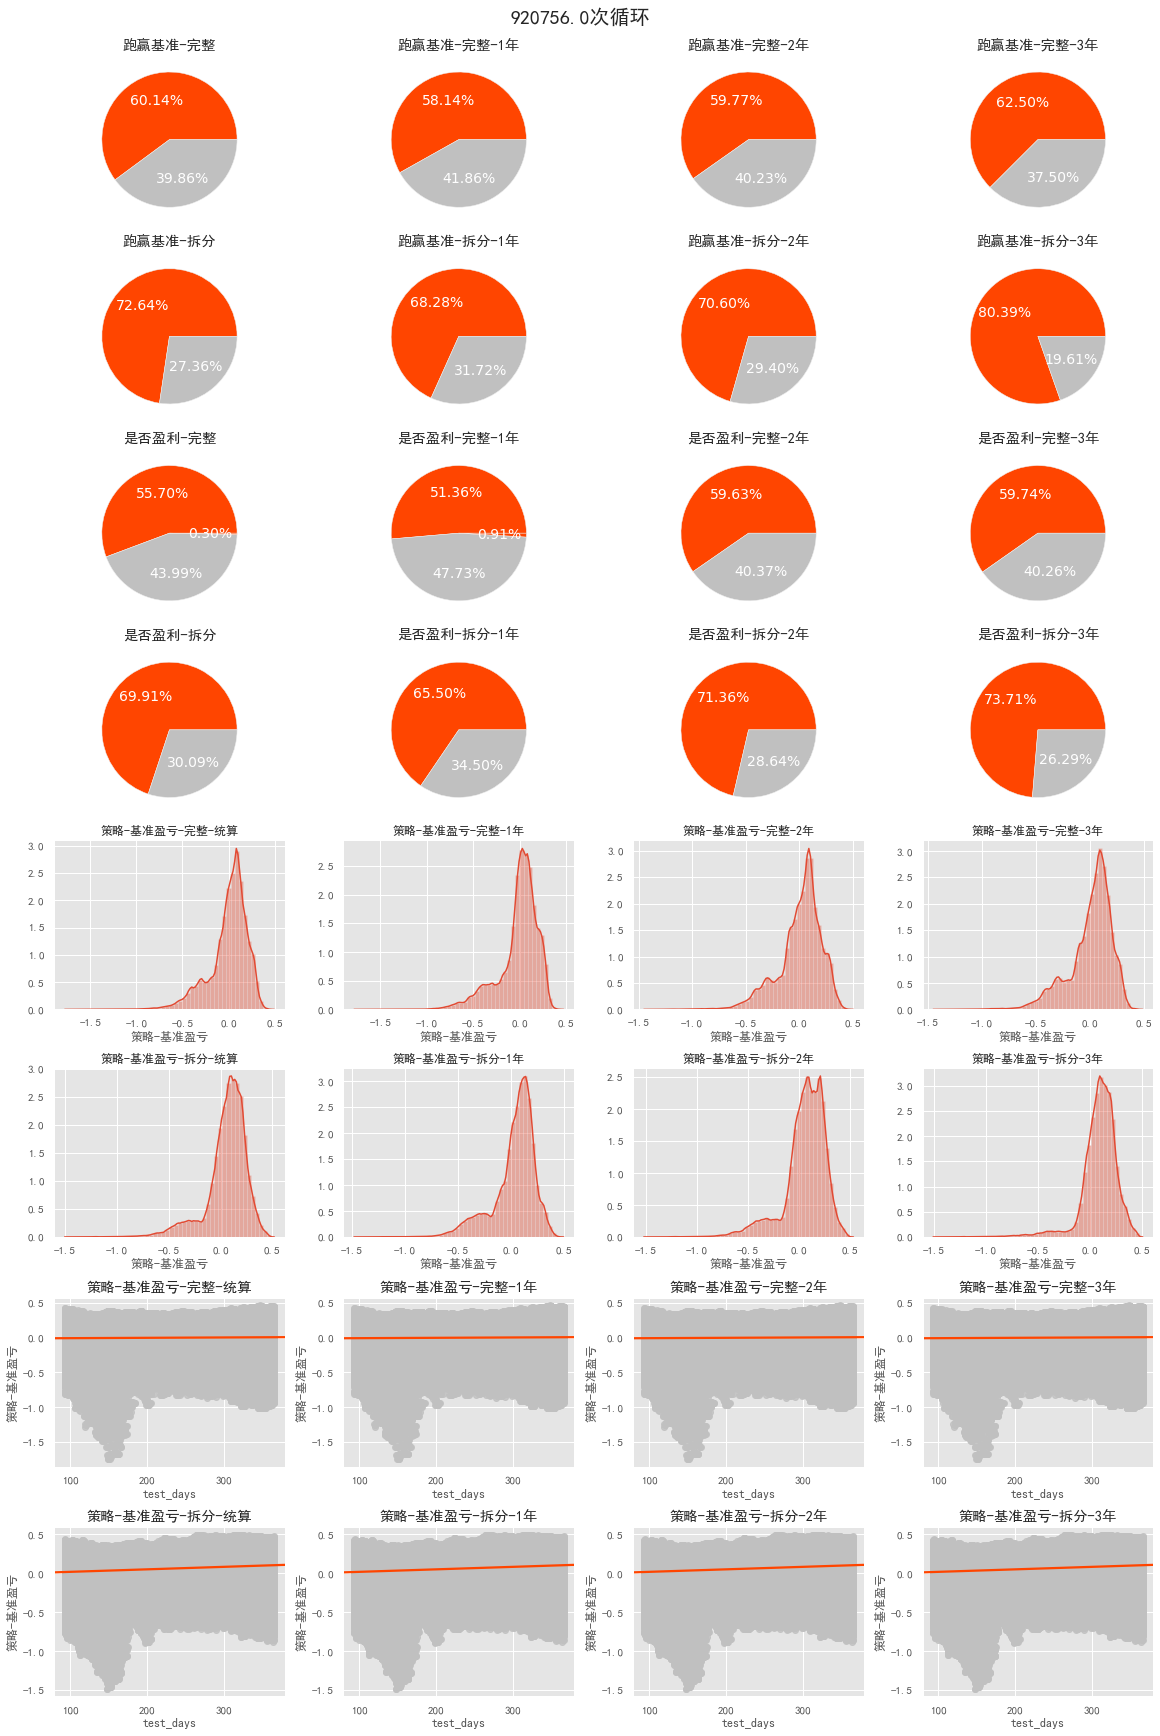

In [15]:
from IPython.display import clear_output
clear_output(wait=True)
report_plot(report_1000000)